MLP with numpy:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Запустим "framework.ipynb":

In [2]:
%run framework.ipynb

ReLU custom:
 [1 2 0 4 0]
ReLU torch:
 tensor([1., 2., 0., 4., 0.], grad_fn=<ReluBackward0>)
ReLU backward torch:
 tensor([1., 1., 0., 1., 0.])
ReLU backward custom:
 [1. 1. 0. 1. 0.]
LeakyReLU custom:
 [ 1.    2.   -0.15  4.   -0.35]
LeakyReLU torch:
 tensor([ 1.0000,  2.0000, -0.1500,  4.0000, -0.3500],
       grad_fn=<LeakyReluBackward0>)
LeakyReLU backward torch:
 tensor([1.0000, 1.0000, 0.0500, 1.0000, 0.0500])
LeakyReLU backward custom:
 [1.   1.   0.05 1.   0.05]
custom:
 [[0.63575811 0.28377758]
 [0.63575811 0.28377758]]
torch:
 tensor([[0.6358, 0.2838],
        [0.6358, 0.2838]], grad_fn=<SigmoidBackward>)
Sigmoid backward torch:
 tensor([[0.2316, 0.2032],
        [0.2316, 0.2032]])
Sigmoid backward custom:
 [[0.23156973 0.20324786]
 [0.23156973 0.20324786]]
custom:
 [[0.14411375 0.19483054 0.2964141  0.18951442 0.17512719]
 [0.171789   0.29275732 0.16280605 0.13662478 0.23602285]
 [0.19533533 0.17744226 0.21988101 0.19549432 0.21184708]]
torch:
 tensor([[0.1441, 0.1948, 0.296

Реализация оптимизаторов (SGD, RMSProp и Adam):

In [3]:
class SGD():
    def __init__(self, lr=1e-3):
        self.lr = lr

    def forward(self, params, gradients):
        for weights, gradient in zip(params, gradients):
            weights -= self.lr * gradient

In [4]:
class RMSProp():
    def __init__(self, params, lr=1e-3, momentum=0.0, alpha=0.75, eps=1e-08):
        self.lr = lr
        self.momentum = momentum
        self.alpha = alpha
        self.eps = eps
        self.buffer = [np.zeros(shape=elem.shape) for elem in params]
        self.velocity = [np.zeros(shape=elem.shape) for elem in params]

    def forward(self, parameters, gradients):
        for weights, vel, buf, gradient in zip(parameters, self.velocity, self.buffer, gradients):
            vel = self.alpha * vel + (1 - self.alpha) * gradient**2
            buf = self.momentum * buf + gradient / (np.sqrt(vel) + self.eps)
            weights -= self.lr * buf

In [5]:
class Adam():
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-08):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.buffer = [np.zeros(shape=elem.shape) for elem in params]
        self.velocity = [np.zeros(shape=elem.shape) for elem in params]

    def forward(self, parameters, gradients):
        for weights, vel, buf, gradient in zip(parameters, self.velocity, self.buffer, gradients):
            vel = self.beta1 * vel + (1 - self.beta1) * gradient
            buf = self.beta2 * buf + (1 - self.beta2) * gradient ** 2
            vel_t = vel / (1 - self.beta1)
            buf_t = buf / (1 - self.beta2)
            weights -= self.lr * vel_t / (np.sqrt(buf_t) + self.eps)

Простейший вариант Dataloader:

In [6]:
def loader(X, Y, batch_size):    
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

Для нормальной работы нужно запустить ячейку ниже 2 раза. Не переписана согласно п.1 кодекса инженера*

*п.1 кодекса инженера: "Работает - не трогай"

In [7]:
import os
from sklearn.datasets import fetch_openml

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Функция для отображения элементов датасета - чтобы убедиться, что все работает корректно:

2


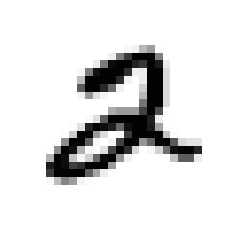

In [8]:
def imshow(img, label):
    pic = img.astype('float').reshape(28, 28)
    plt.axis('off')
    print(label)
    return plt.imshow(pic, cmap='Greys')

numba = 5
imshow(X[numba], y[numba])

Разделим датасет на train и validation.

In [9]:
import copy

test_size = 0.1
val_size = X.shape[0] * 0.1

X_train = copy.deepcopy(X[ : int(X.shape[0] * (1 - test_size))])
Y_train = copy.deepcopy(y[ : int(X.shape[0] * (1 - test_size))])

X_val = copy.deepcopy(X[ int(X.shape[0] * (1 - test_size)) : ])
Y_val = copy.deepcopy(y[ int(X.shape[0] * (1 - test_size)) : ])

Переведем лейблы в one-hot.

In [10]:
nb_classes = 10
targets_train = np.array(list(map(int, Y_train)))
one_hot_targets_train = np.eye(nb_classes, dtype=int)[targets_train]

In [11]:
targets_val = np.array(list(map(int, Y_val)))
one_hot_targets_val = np.eye(nb_classes, dtype=int)[targets_val]

Функция для отображения кривых обучения:

In [12]:
def plot_training(train, val):
    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(range(len(train)), train, label='Train Error')
    plt.plot(range(len(val)), val, label='Val Error')
    plt.legend()
    plt.grid()
    plt.show()

Для метрики accuracy воспользуемся библиотекой sklearn:

In [13]:
from sklearn.metrics import accuracy_score

In [20]:
model = Sequential(
    Linear(784, 512),
    BatchNorm(512),
    LeakyReLU(),
    Linear(512, 512),
    BatchNorm(512),
    LeakyReLU(),
    Linear(512, 10),
    SoftMax(),
)

criterion = CrossEntropy()
batch_size = 128
epoch = 25
optimizer = Adam(model.parameters(), lr=1e-4)

Функция для обучения модели, считающая точность на валидации на каждой эпохе, а также возвращающая списки лоссов (тренировочного и валидационного) для всех эпох:

In [18]:
def train_loop(model, criterion, batch_size, epoch, optimizer):
    train_losses = []
    val_losses = []
    for i in range(epoch):
        acc_train = []
        acc_val = []
        train_loss = []
        val_loss = []
        model.train()
        for x, y_true in loader(X_train, one_hot_targets_train, batch_size):
            y_pred = model.forward(x)
            y_pred_for_acc = np.argmax(y_pred, axis=1)
            y_true_for_acc = np.argmax(y_true, axis=1)
            loss_train = criterion.forward(y_pred, y_true)
            acc_train.append(accuracy_score(y_true_for_acc, y_pred_for_acc))
            grad = criterion.backward(y_pred, y_true)
            model.backward(x, grad)
            optimizer.forward(model.parameters(), model.grad_parameters())
            train_loss.append(loss_train)

        if epoch % 1 == 0:
            model.eval()
            for x, y_true in loader(X_val, one_hot_targets_val, batch_size):
                y_pred = model.forward(x)
                loss_val = criterion.forward(y_pred, y_true)
                val_loss.append(loss_val)
                y_pred_for_acc = np.argmax(y_pred, axis=1)
                y_true_for_acc = np.argmax(y_true, axis=1)
                acc_val.append(accuracy_score(y_true_for_acc, y_pred_for_acc))
                
        print('--Train--')
        print('Epoch: {}, Accuracy: {}, Loss {}'.format(i, np.mean(acc_train), np.mean(train_loss)))
        print('--Validation--')
        print('Epoch: {}, Accuracy: {}, Loss {}'.format(i, np.mean(acc_val), np.mean(val_loss)))
        print()
        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
    return train_losses, val_losses

In [21]:
full_train_loss, full_val_loss = train_loop(model, criterion, batch_size, epoch, optimizer)

--Train--
Epoch: 0, Accuracy: 0.8647840601757943, Loss 1.6325367064840541
--Validation--
Epoch: 0, Accuracy: 0.9331224173553718, Loss 1.5289932309401384

--Train--
Epoch: 1, Accuracy: 0.9242942866801893, Loss 1.5374651428929775
--Validation--
Epoch: 1, Accuracy: 0.9494705578512397, Loss 1.5110599139221343

--Train--
Epoch: 2, Accuracy: 0.9407010649087221, Loss 1.520403252591783
--Validation--
Epoch: 2, Accuracy: 0.9571280991735537, Loss 1.503955733717264

--Train--
Epoch: 3, Accuracy: 0.9498341362407032, Loss 1.5112070098581811
--Validation--
Epoch: 3, Accuracy: 0.9634555785123967, Loss 1.4978183965074088

--Train--
Epoch: 4, Accuracy: 0.956125338066261, Loss 1.5049077438526934
--Validation--
Epoch: 4, Accuracy: 0.967058367768595, Loss 1.4939276410807643

--Train--
Epoch: 5, Accuracy: 0.959891607505071, Loss 1.5010984275907662
--Validation--
Epoch: 5, Accuracy: 0.9700542355371901, Loss 1.4913683620096978

--Train--
Epoch: 6, Accuracy: 0.9636578769438809, Loss 1.497383638893957
--Valida

Кривые обучения:

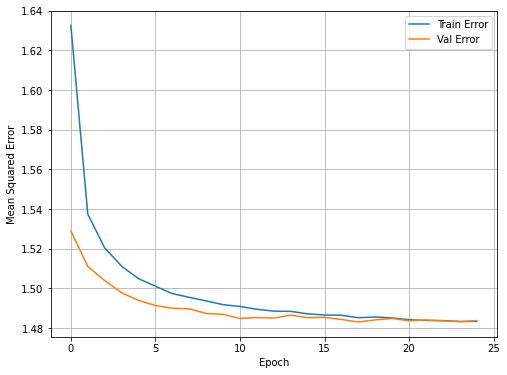

In [22]:
plot_training(full_train_loss, full_val_loss)